In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

# Ex 6.1

In [2]:
def gaussian1DKernel(sigma):
    '''
    sigma: standard deviation 
    '''
    
    half_length = np.ceil(4*sigma)               ## half_length = n*sigma in (u+n*sigma)
                                                 ## np.ceil: up floor 
    x = np.arange(-half_length, half_length+1).reshape(-1,1)
    g =1/np.sqrt(2 * math.pi * (sigma**2)) * np.exp(-x**2 / (2*(sigma**2)))
    gd = -x/(sigma**2) * g
    return g, gd

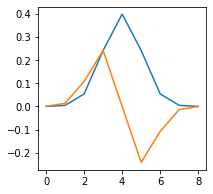

In [5]:
g, gd = gaussian1DKernel(1)
plt.figure(figsize=(3,3))
ax = plt.axes()
ax.plot(g)
ax.plot(gd)

# Ex 6.2

In [18]:
def gaussianSmoothing(im, sigma):
    g, gd = gaussian1DKernel(sigma)
    I = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, g)
    Ix = cv2.filter2D(cv2.filter2D(im, -1, gd.T), -1, g)
    Iy = cv2.filter2D(cv2.filter2D(im, -1, g.T), -1, gd)
    return I, Ix, Iy
    

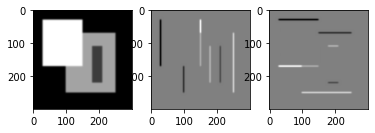

In [23]:
img = cv2.imread('./week06_data/TestIm1.png').astype('float32')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
I, Ix, Iy = gaussianSmoothing(gray, 2)
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Ix, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Iy, cmap='gray')

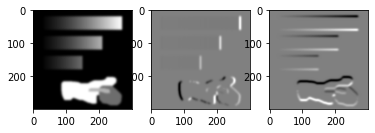

In [24]:
img = cv2.imread('./week06_data/TestIm2.png').astype('float32')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
I, Ix, Iy = gaussianSmoothing(gray, 3)
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Ix, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Iy, cmap='gray')

# Ex 6.3

In [25]:
def smoothedHessian(im, sigma, epsilon):
    ge, _ = gaussian1DKernel(epsilon)
    I, Ix, Iy = gaussianSmoothing(im, sigma)
    
    '''
    Cx = cv2.filter2D(cv2.filter2D(Ix*Ix, -1, g), -1, g.T)
    Cxy = cv2.filter2D(cv2.filter2D(Ix*Iy, -1, g), -1, g.T)
    Cy = cv2.filter2D(cv2.filter2D(Iy*Iy, -1, g), -1, g.T)
    
    '''
    Cx = cv2.filter2D(Ix**2, -1, ge)
    Cxy = cv2.filter2D(Ix*Iy, -1, ge)
    Cy = cv2.filter2D(Iy**2, -1, ge)
    
    return Cx, Cxy, Cy

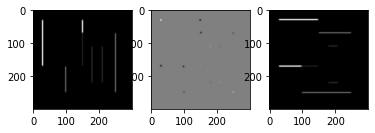

In [26]:
img = cv2.imread('./week06_data/TestIm1.png').astype('float32')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Cx, Cxy, Cy = smoothedHessian(gray, 2, 0.3)
plt.subplot(1,3,1)
plt.imshow(Cx, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Cxy, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Cy, cmap='gray')

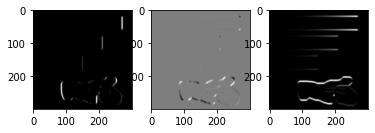

In [27]:
img = cv2.imread('./week06_data/TestIm2.png').astype('float32')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Cx, Cxy, Cy = smoothedHessian(gray, 2, 1)
plt.subplot(1,3,1)
plt.imshow(Cx, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(Cxy, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Cy, cmap='gray')

# Ex 6.4

In [39]:
def harrisMeasure(im, sigma, epsilon, k):
    Cx, Cxy, Cy = smoothedHessian(im, sigma, epsilon)
    r = Cx*Cy - Cxy**2 - k*((Cx + Cy)**2)
    return r

In [65]:
img = cv2.imread('./week06_data/TestIm2.png').astype('float32')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
r = harrisMeasure(gray, 2, 0.33, 0.06)
print(np.where(r==np.max(r)))

(array([234]), array([208]))


In [66]:
0.8*r.astype('uint8').max()

204.0

In [67]:
0.1*r.astype('uint8').max()

25.5

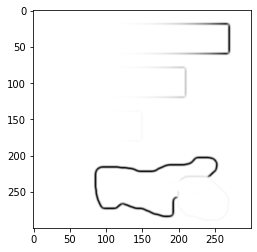

In [68]:
plt.imshow(r, cmap='gray')

# Ex 6.5

In [46]:
def cornerDetector(im, sigma, epsilon, k, tau):
    c = np.zeros_like(im)
    r = harrisMeasure(im.copy(), sigma, epsilon, k)
    r = r.astype('uint8')
    #print('r', r.astype('uint8').min())
    for i in range(1, r.shape[0]-1):
        for j in range(1, r.shape[1]-1):
            if r[i, j] > tau and r[i,j]>r[i+1,j] and r[i,j]>=r[i-1,j] and r[i,j]>r[i,j+1] and r[i,j]>=r[i,j-1]:
                c[i,j] = 1
    
    corners = np.asarray(np.where(c==1)).T
    return corners

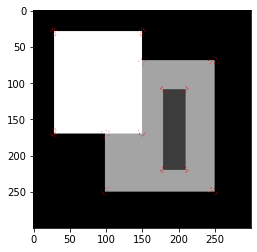

In [69]:
img = cv2.imread('./week06_data/TestIm1.png').astype('float32')
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
#corners = cornerDetector(gray, 2, 0.3, 0.06, 100)  ## tau = (0.1*r.max()) ~ (0.8*r.max())
corners = cornerDetector(gray, 2, 0.3, 0.06, 240)  ## tau = (0.1*r.max()) ~ (0.8*r.max())
for corner in corners:
    img[corner[0], corner[1]] = [255, 0, 0]
plt.imshow(img.astype('uint8'))


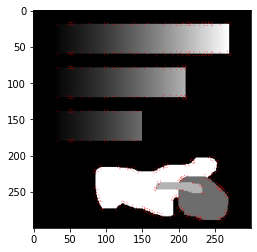

In [82]:
img = cv2.imread('./week06_data/TestIm2.png').astype('float32')
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
corners = cornerDetector(gray, 1, 0.3, 0.06, 240)  ## tau = (0.1*r.max()) ~ (0.8*r.max())
for corner in corners:
    img[corner[0], corner[1]] = [255, 0, 0]
plt.imshow(img.astype('uint8'))

# Ex 6.6

In [83]:
def cv_show(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)                  ## Press any key to interrupt
    cv2.destroyAllWindows()


In [84]:
img1 = cv2.imread('./week06_data/TestIm1.png')
gray1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2GRAY)

img2 =cv2.imread('./week06_data/tristan.png')
gray2 = cv2.cvtColor(img2.copy(), cv2.COLOR_BGR2GRAY)

img3 =cv2.imread('./week06_data/Donald.png')
gray3 = cv2.cvtColor(img3.copy(), cv2.COLOR_BGR2GRAY)


In [85]:
Canny1 = cv2.Canny(gray1.copy(), 100, 200)
cv_show('test1',Canny1)

In [86]:
Canny21 = cv2.Canny(gray2.copy(), 50, 100)
Canny22 = cv2.Canny(gray2.copy(), 200, 400)
Canny23 = cv2.Canny(gray2.copy(), 500, 600)
Canny24 = cv2.Canny(gray2.copy(), 800, 1000)
test2 = np.hstack((gray2, Canny21, Canny22, Canny23, Canny24))
cv_show('test2',test2)

In [87]:
Canny31 = cv2.Canny(gray3.copy(), 50, 100)
Canny32 = cv2.Canny(gray3.copy(), 200, 400)
Canny33 = cv2.Canny(gray3.copy(), 500, 600)
Canny34 = cv2.Canny(gray3.copy(), 800, 1000)
test3 = np.hstack((gray3, Canny31, Canny32, Canny33, Canny34))
cv_show('test3',test3)